In [8]:
# Se requiere Python ≥ 3.5
import sys;
assert sys.version_info >= (3, 5);

# Se requiere Scikit-Learn ≥ 0.20
import sklearn;
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
assert sklearn.__version__ >= "0.20";

# Otros imports
import numpy as np;
import pandas as pd
from pandas.plotting import scatter_matrix;
import xgboost as xgb 
import matplotlib as mpl
import matplotlib.pyplot as plt;

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# tamaño del texto en las etiquetas por defecto
mpl.rc('axes',  labelsize=14);
mpl.rc('xtick', labelsize=12);
mpl.rc('ytick', labelsize=12);

### Lo primero que haremos es observar los datos del CSV

In [3]:
insurence_df = pd.read_csv("./dataset/insurance.csv")

In [4]:
insurence_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Se aprecia lo siguiente: 
- Hay tres columnas categoricas
- No hay valores null
- No hay valores NaN

In [5]:
insurence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
insurence_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- Mostramos las graficas de los datos aritméticos

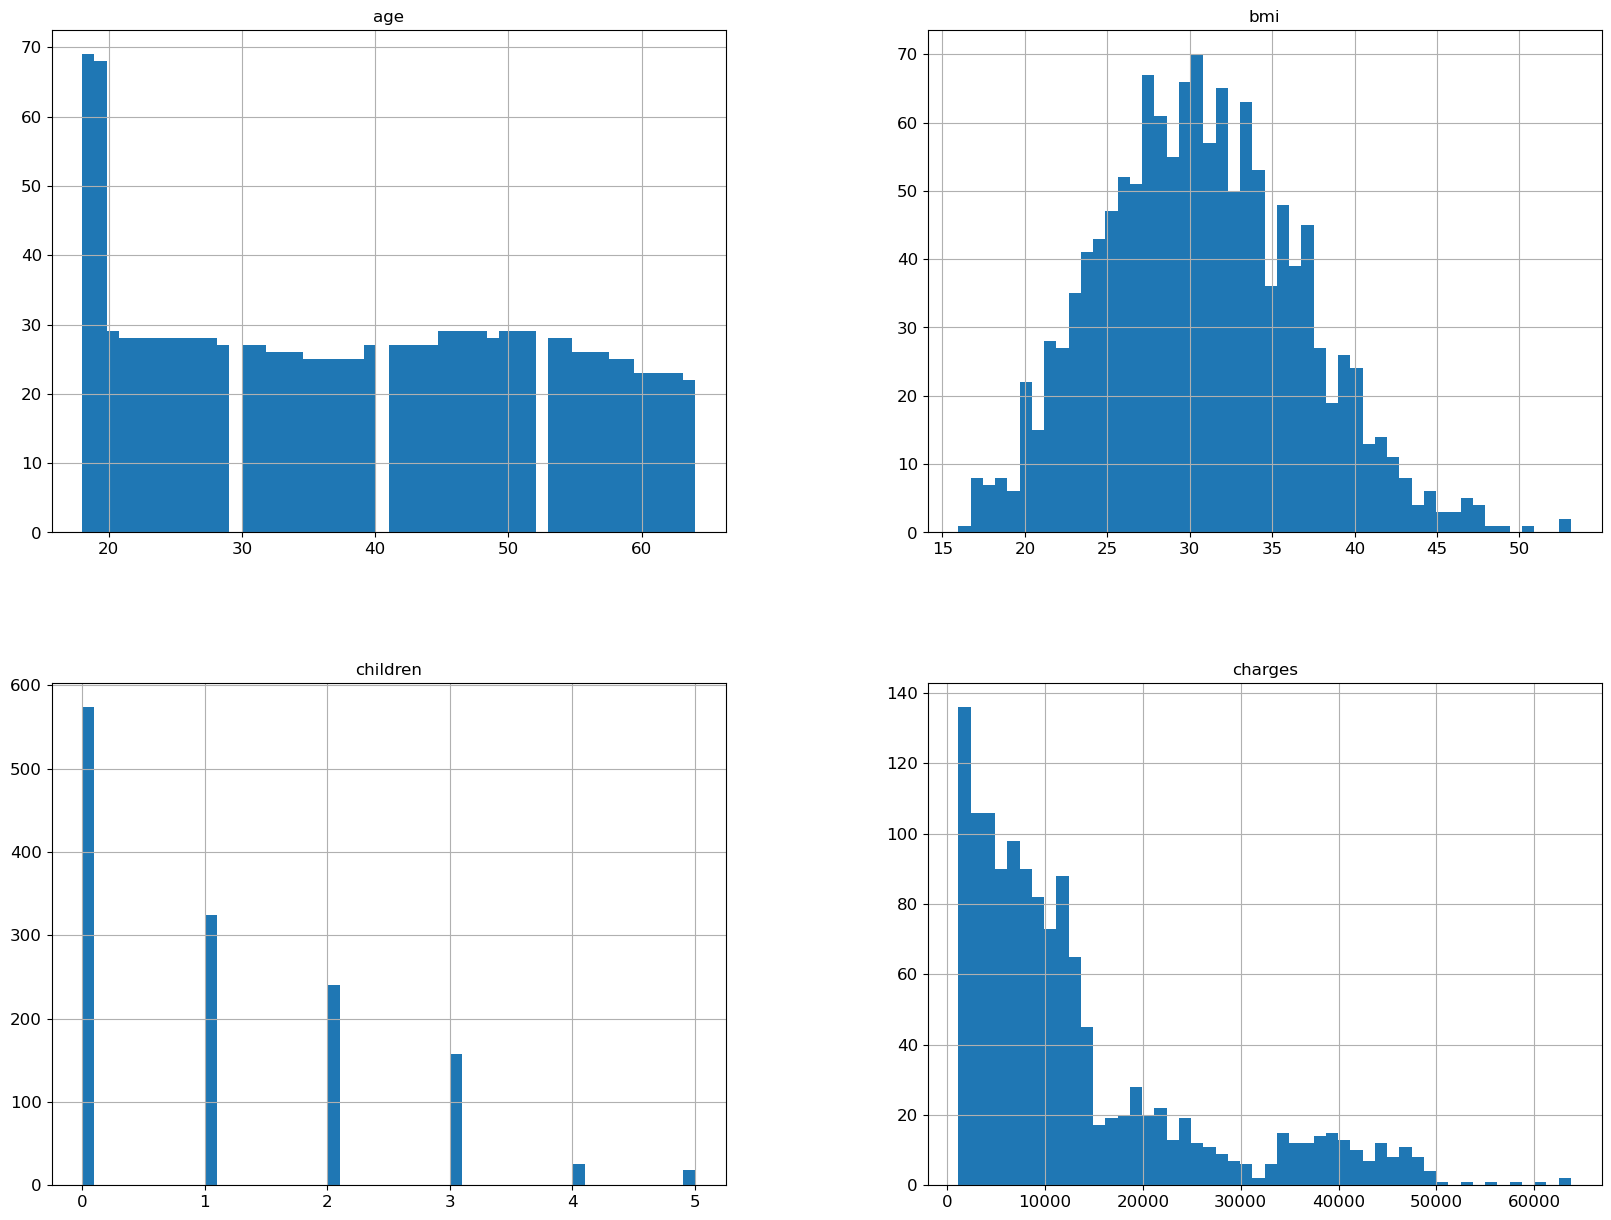

In [7]:
insurence_df.hist(bins=50, figsize=(20,15));

#### Analizamos las correlaciones

In [13]:
corr_matrix = insurence_df.corr();

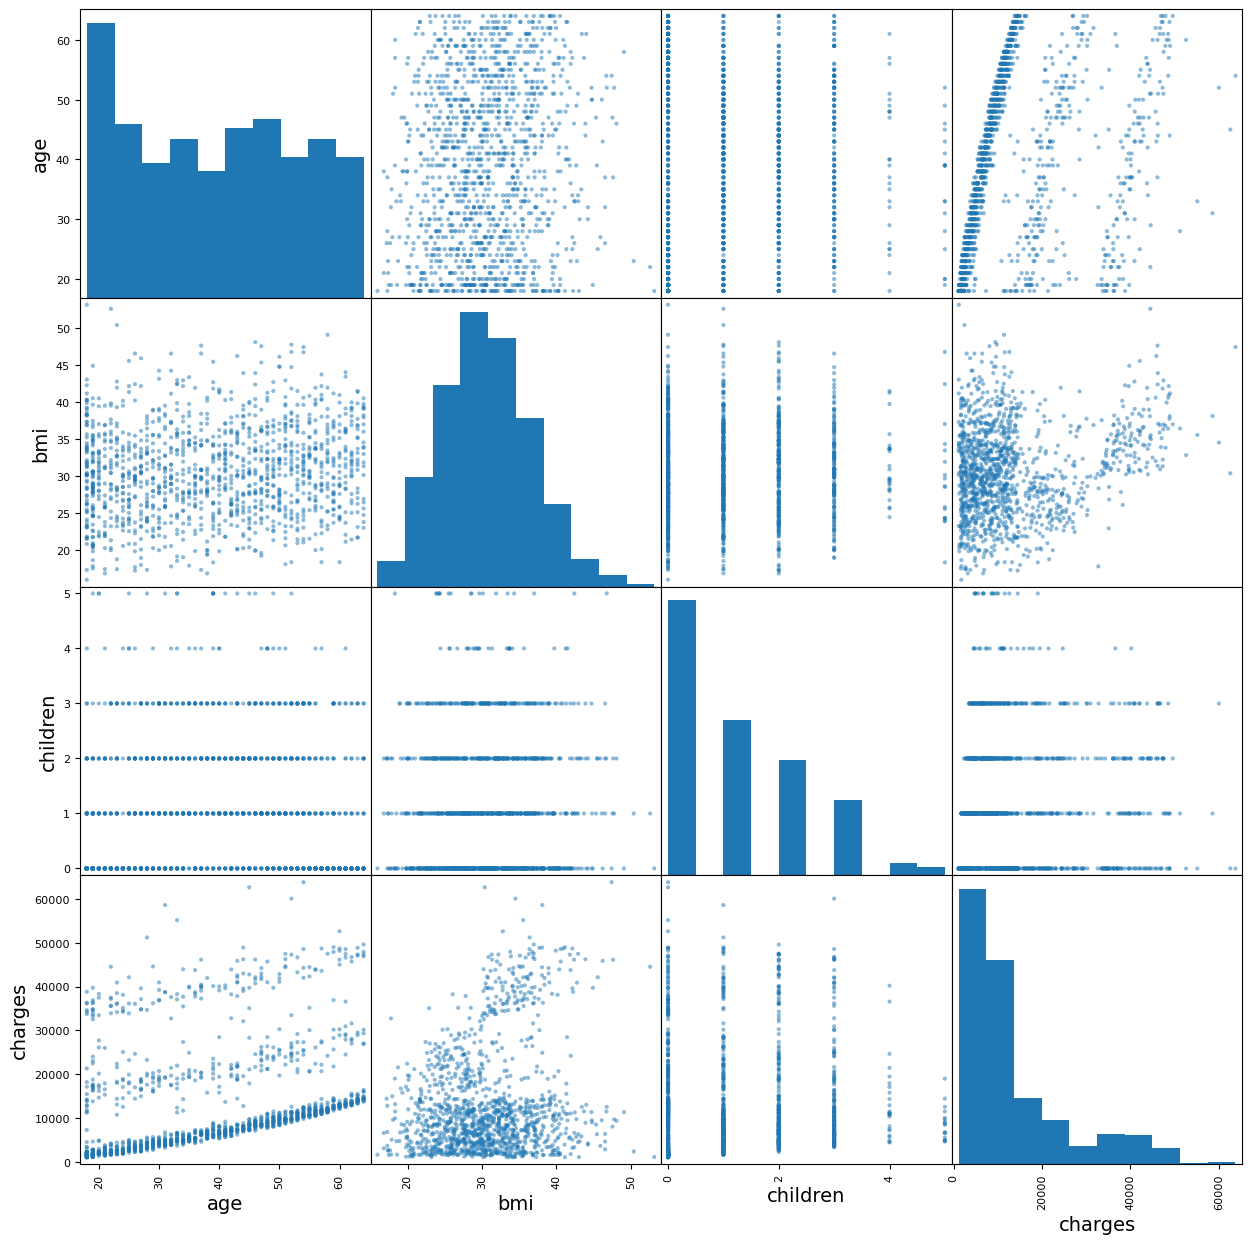

In [14]:
attributes = ['age','bmi','children','charges']
scatter_matrix(insurence_df[attributes], figsize=(15, 15));

- En un primer momento las columnas no estan apenas correlacionadas con la columna cargos

In [15]:
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

In [33]:
copy_corr = insurence_df.copy()
copy_corr['age+30'] = copy_corr['age'] >= 30
copy_corr['age-30'] = copy_corr['age'] < 30
copy_corr['smoker_yes'] = copy_corr['smoker'] == 'yes'
copy_corr['age_per_smoker'] = copy_corr['age'] / copy_corr[copy_corr['smoker'] == 'yes']
copy_corr['children_per_age'] =  copy_corr['children'] / copy_corr['age']
copy_corr['bmi_per_age'] =  copy_corr['bmi'] / copy_corr['age']
corr_matrix1 = copy_corr.corr();
corr_matrix1["charges"].sort_values(ascending=False)

ValueError: Expected a 1D array, got an array with shape (1338, 1347)

#### Tratamiento de columnas categoricas

- Hacemos una copia del dataframe principal y substraemos las columnas categoricas

In [11]:
copy = insurence_df.copy()
copy_cat = copy[["sex", "smoker","region"]]
copy_cat


,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


- Utilizamos la clase OneHotEncoder, la cual nos permitirá crear una columna por cada valor categorico. Esta columna solo tendra dos valores aritmeticos, 1 o 0.

In [12]:
for col in copy_cat.columns:
    oneHot_encoder = OneHotEncoder(sparse=False)
    cat_1hot_encoded = oneHot_encoder.fit_transform(copy_cat[[col]])
    copy.reset_index(drop=False, inplace=True)
    copy=copy.join(pd.DataFrame(cat_1hot_encoded, columns=[cat for cat in oneHot_encoder.categories_[0]]))
    copy=copy.drop([col,'index'], axis=1);
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   bmi        1338 non-null   float64
 2   children   1338 non-null   int64  
 3   charges    1338 non-null   float64
 4   female     1338 non-null   float64
 5   male       1338 non-null   float64
 6   no         1338 non-null   float64
 7   yes        1338 non-null   float64
 8   northeast  1338 non-null   float64
 9   northwest  1338 non-null   float64
 10  southeast  1338 non-null   float64
 11  southwest  1338 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 125.6 KB


In [30]:
np.random.seed(42)
def split_train_test(data, test_ratio):
    test_set_size   = int(len(data)*test_ratio)
    shuffle_indices = np.random.permutation(len(data))
    test_indices    = shuffle_indices[:test_set_size]
    train_indices   = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [31]:
X_train, X_test = split_train_test(copy, 0.20)
len(X_train), len(X_test)

(1071, 267)

In [32]:
y_train = X_train["charges"].copy();
X_train = X_train.drop("charges", axis=1);
y_test = X_test["charges"].copy();
X_test = X_test.drop("charges", axis=1);

In [33]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1071 entries, 846 to 1126
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1071 non-null   int64  
 1   bmi        1071 non-null   float64
 2   children   1071 non-null   int64  
 3   female     1071 non-null   float64
 4   male       1071 non-null   float64
 5   no         1071 non-null   float64
 6   yes        1071 non-null   float64
 7   northeast  1071 non-null   float64
 8   northwest  1071 non-null   float64
 9   southeast  1071 non-null   float64
 10  southwest  1071 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 100.4 KB


In [64]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_train)
print(f"Prediccion (regresion lineal) = {lin_pred}")

lin_rmse = np.sqrt(mean_squared_error(y_train, lin_pred))
print(f"MSE (regresion lineal) = {lin_rmse}")

lin_mae = mean_absolute_error(y_train, lin_pred)
print(f"MAE (regresion lineal) = {lin_mae}")

scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

display_scores(lin_rmse_scores)

# scores = cross_val_score(lin_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
# lin_rmse_scores = np.sqrt(-scores)
# print("==TEST==")
# display_scores(lin_rmse_scores)

Prediccion (regresion lineal) = [12304.78360104  7093.24787847  8341.85211315 ... 11441.23189993
 37301.46107557 11444.01522502]
MSE (regresion lineal) = 6103.149147866421
MAE (regresion lineal) = 4205.4945226997215
Scores: [6050.40909382 6581.19463198 5233.73232452 6046.27603172 5834.93921788
 6126.4056795  7281.69654993 6321.66880206 6193.13545932 5637.27658837]
Mean: 6130.673437910753
Standard deviation: 521.2667575944301


In [59]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_train)
print(f"Prediccion (arbol de decision) = {tree_pred}")

tree_rmse = np.sqrt(mean_squared_error(y_train, tree_pred))
print(f"MSR (arbol de decision)= {tree_rmse}")

tree_mae = mean_absolute_error(y_train, tree_pred)
print(f"MAE (arbol de decision)= {tree_mae}")

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

# scores = cross_val_score(tree_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
# tree_rmse_scores = np.sqrt(-scores)
# print("==TEST==")
# display_scores(tree_rmse_scores)

Prediccion (arbol de decision) = [ 9872.701    9193.8385   8534.6718  ... 11931.12525 46113.511
 10214.636  ]
MSR (arbol de decision)= 493.97520812856715
MAE (arbol de decision)= 29.544903267973854
Scores: [5896.19517636 6549.94095262 7203.92852608 7013.98162429 7276.27382822
 6235.89364979 7632.35453201 6969.67144186 6375.35240122 5733.07999096]
Mean: 6688.667212341234
Standard deviation: 595.7926038315205


In [45]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)
forest_pred = forest_reg.predict(X_train)
print(f"Prediccion (random forest) = {forest_pred}")

forest_rmse = np.sqrt(mean_squared_error(y_train, forest_pred))
print(f"MSR (random forest)= {forest_rmse}")

forest_mae = mean_absolute_error(y_train, forest_pred)
print(f"MAE (random forest)= {forest_mae}")

scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

scores = cross_val_score(forest_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
print("==TEST==")
display_scores(forest_rmse_scores)

Prediccion (random forest) = [ 9861.559064  10043.5613483 11167.5573245 ... 12419.5509927 45535.6536986
 10899.9124699]
MSR (random forest)= 1866.8169773913985
MAE (random forest)= 1041.4363725823225
Scores: [4833.61316928 5335.79896933 3874.4623029  4510.45038763 5283.6891429
 4994.60524961 5554.10266916 5424.99230724 5145.74589683 4705.97649004]
Mean: 4966.343658490828
Standard deviation: 480.7765089665845
==TEST==
Scores: [2268.28873116 5499.26829176 5249.3855296  3989.69841208 5783.81886813
 4961.90595617 4477.13018983 4829.9215878  4214.52742236 6024.08578047]
Mean: 4729.803076937884
Standard deviation: 1031.9019084673932


In [43]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
svm_pred = svm_reg.predict(X_train)
print(f"Prediccion (SVR) = {svm_pred}")

svm_rmse = np.sqrt(mean_squared_error(y_train, svm_pred))
print(f"MSR (SVR)= {svm_rmse}")

svm_mae = mean_absolute_error(y_train, svm_pred)
print(f"MAE (SVR)= {svm_mae}")

scores = cross_val_score(svm_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

display_scores(svm_rmse_scores)

# scores = cross_val_score(svm_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
# svm_rmse_scores = np.sqrt(-scores)
# print("==TEST==")
# display_scores(svm_rmse_scores)

Prediccion (SVR) = [10458.02049367  9368.2352541   9224.07278237 ... 12026.53641681
  7499.98495701 11138.09604864]
MSR (SVR)= 12791.707652091878
MAE (SVR)= 6545.56351170418
Scores: [13062.38471663 12585.4826409  12571.66578656 15088.20074018
 12910.00713165 10554.16838977 13116.25055334 12522.90187548
 12899.12633482 12338.13035153]
Mean: 12764.831852084833
Standard deviation: 1041.455864021634


In [44]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror",
                           random_state=42)

xgb_reg.fit(X_train, y_train)
xgb_pred=xgb_reg.predict(X_train)
print(f"Prediccion (XGB) = {xgb_pred}")

xgb_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred))
print(f"MSR (XGB)= {xgb_rmse}")

xgb_mae = mean_absolute_error(y_train, xgb_pred)
print(f"MAE (XGB)= {xgb_mae}")

scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-scores)

display_scores(xgb_rmse_scores)

# scores = cross_val_score(xgb_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
# xgb_rmse_scores = np.sqrt(-scores)
# print("==TEST==")
# display_scores(xgb_rmse_scores)

Prediccion (XGB) = [ 9272.214  9087.22  10352.296 ... 12048.301 45654.09  10792.25 ]
MSR (XGB)= 979.8649859596401
MAE (XGB)= 528.9684601236067
Scores: [5256.96954726 5656.84924118 3893.22834672 4807.06084593 5621.63466402
 4977.97849212 6044.91593247 5877.19091089 5250.23666664 5387.88481239]
Mean: 5277.39494596176
Standard deviation: 587.4925142080037
